In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import ast
from tqdm import tqdm
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import rankdata
from tqdm import tqdm
sns.set_context('talk')
%load_ext blackcellmagic

def nd(arr):
    return np.asarray(arr).reshape(-1)

In [3]:
# Useful dictionary (gene ids to gene name and viceversa)
gene_ids = pd.read_csv("/home/agalvezm/projects/cca/human/data/adipose/GSM3711757/gene_ids.txt.gz", header = None)
gene_names = pd.read_csv("/home/agalvezm/projects/cca/human/data/adipose/GSM3711757/genes.txt.gz", header = None)

gene_id_to_name = dict(pd.concat([gene_ids, gene_names] , axis = 1).values)
gene_name_to_id = dict(pd.concat([gene_names, gene_ids] , axis = 1).values)

In [4]:
organ = 'testis'
#assignment_type = 'rank_mx'
assignment_type = 'rank_mx'



home = '/home/cellatlas'
home_output = '/home/agalvezm/projects/cca'
dicts_path = f"{home_output}/notebooks/files"
markers_path = f'{home}/human/markers/{organ}/markers.txt'

tcc_mat_path = f"{home_output}/split_by_celltype/tcc/{organ}"


transcripts_df = pd.read_csv(f'{dicts_path}/transcripts.txt', header = None)
transcripts_df.insert(0, column = 'ec', value = transcripts_df.index)
TX_to_ENST = dict(transcripts_df.values)

t2g = pd.read_csv(f'{dicts_path}/t2g.txt', sep = '\t', header = None)
ENST_to_ENSG = dict(t2g[[0,1]].values)
ENSG_to_name = dict(t2g[[1,2]].values)

name_to_ENSG = {v: k for k, v in ENSG_to_name.items()}


# Read ENSG_to_ec map
ENSG_to_ecs_df = pd.read_csv(f'{home_output}/ec_unions/{organ}/ENSG_to_ecs.tsv', sep = '\t', header = None)

ENSG_to_ecs = dict(ENSG_to_ecs_df.values)

ecs_to_ENSG = {v: k for k, v in ENSG_to_ecs.items()}



# Get cell types
celltypes = pd.read_csv(markers_path, sep = '\t', header = None)[0].values


genes_results_folder = f'/home/agalvezm/projects/cca/isoform_gene_de/genes_ttest'
isoforms_results_folder = f'/home/agalvezm/projects/cca/tcm_ttests'

In [5]:
# Set order for testis
if organ == "testis":
    celltypes = [
        "Spermatogonia",
        "Spermatocyte",
        "RoundSpermatid",
        "Elongating",
        "Endothelial",
        "ImmLeydig",
        "Macrophage",
        "Myoid",
        "Tcell",
#        "f-Pericyte",
        "m-Pericyte",
    ]

#### Read t-test results

In [6]:
# Read t-test results
genes_results = {}
for celltype in celltypes:
    genes_results[celltype] = pd.read_csv(f'{genes_results_folder}/{organ}/{celltype}/results_{assignment_type}.csv')
    
isoforms_results = {}
for celltype in celltypes:
    #isoforms_results[celltype] = pd.read_csv(f'{isoforms_results_folder}/{organ}/{celltype}_new/results_{assignment_type}.csv')
    isoforms_results[celltype] = pd.read_csv(f'{isoforms_results_folder}/{organ}/{celltype}/results_{assignment_type}.csv')



# Apply bonferroni correction
# Compute the number of p-values in the column
for celltype in celltypes:
    
    # Genes
    n = genes_results[celltype]["p-value"].size
    # Compute the Bonferroni correction factor
    bonferroni_correction_gene = 0.05 / n
    # Apply the correction to the p-values in the column
    genes_results[celltype]['corrected_pvalue'] = genes_results[celltype]["p-value"] / bonferroni_correction_gene
    # Impose upperbound of 1 for p-values
    genes_results[celltype]['corrected_pvalue'] = [p if p <1 else 1 for p in genes_results[celltype]['corrected_pvalue']]
    
    # Isoforms
    n = isoforms_results[celltype]["p-value"].size
    # Compute the Bonferroni correction factor
    bonferroni_correction_isoform = 0.05 / n
    # Apply the correction to the p-values in the column
    isoforms_results[celltype]['corrected_pvalue'] = isoforms_results[celltype]["p-value"] / bonferroni_correction_isoform  
    # Impose upperbound of 1 for p-values
    isoforms_results[celltype]['corrected_pvalue'] = [p if p <1 else 1 for p in isoforms_results[celltype]['corrected_pvalue']]
    

# Alternative: to leave p-values alone but use adjusted significance threshold, which are contained
# in the variables bonferroni_correction_gene and bonferroni_correction_isoform


#### Map isoforms to genes

In [7]:
isoforms_genes_results = {}
for celltype in celltypes:

    enst_list = isoforms_results[celltype]['target']
    ensg_list = [ENST_to_ENSG[tx] for tx in enst_list]


    isoforms_results[celltype]['transcript_id'] = enst_list
    isoforms_results[celltype]['gene_id'] = ensg_list
    
    isoforms_genes_results[celltype] = isoforms_results[celltype].merge(genes_results[celltype], left_on = 'gene_id', right_on = 'target', suffixes = ['_isoform', '_gene'])

    isoforms_genes_results[celltype]['-log10_corrected_pvalue_isoform'] = -np.log10(isoforms_genes_results[celltype]['corrected_pvalue_isoform'])
    isoforms_genes_results[celltype]['-log10_corrected_pvalue_gene'] = -np.log10(isoforms_genes_results[celltype]['corrected_pvalue_gene'])
    
    isoforms_genes_results[celltype]['-log10_pvalue_isoform'] = -np.log10(isoforms_genes_results[celltype]['corrected_pvalue_isoform'])
    isoforms_genes_results[celltype]['-log10_pvalue_gene'] = -np.log10(isoforms_genes_results[celltype]['corrected_pvalue_gene'])

/home/agalvezm/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
isoforms_genes_results_tiso = {}
# Only retain values for cases where the gene/isoform is higher in the celltype, not the other way around
for celltype in celltypes:
    isoforms_genes_results_tiso[celltype] = isoforms_genes_results[celltype][isoforms_genes_results[celltype]['t-statistic_isoform'] > 0]

In [9]:
isoforms_genes_results_tiso['Spermatogonia'].head()

,Unnamed: 0_isoform,cell_type_isoform,target_isoform,t-statistic_isoform,p-value_isoform,mean_ct_isoform,mean_no_ct_isoform,effect_size_isoform,std_ct_isoform,std_no_ct_isoform,...,mean_ct_gene,mean_no_ct_gene,effect_size_gene,std_ct_gene,std_no_ct_gene,corrected_pvalue_gene,-log10_corrected_pvalue_isoform,-log10_corrected_pvalue_gene,-log10_pvalue_isoform,-log10_pvalue_gene
0,0,Spermatogonia,ENST00000475760.1,1.084620,2.780999e-01,0.004989,0.004467,0.000521,0.061439,0.057893,...,0.166319,0.147040,0.019279,0.352747,0.401289,1.639079e-05,-0.000000,4.785400,-0.000000,4.785400
1,1,Spermatogonia,ENST00000483528.1,5.318524,1.055737e-07,0.005795,0.003114,0.002681,0.066254,0.049485,...,0.166319,0.147040,0.019279,0.352747,0.401289,1.639079e-05,1.358041,4.785400,1.358041,4.785400
2,2,Spermatogonia,ENST00000497384.1,10.279089,9.916706e-25,0.016606,0.008123,0.008482,0.109217,0.075570,...,0.166319,0.147040,0.019279,0.352747,0.401289,1.639079e-05,18.385229,4.785400,18.385229,4.785400
3,3,Spermatogonia,ENST00000468303.5,10.126398,4.675925e-24,0.090299,0.070727,0.019572,0.247188,0.232289,...,0.166319,0.147040,0.019279,0.352747,0.401289,1.639079e-05,17.711729,4.785400,17.711729,4.785400
4,4,Spermatogonia,ENST00000488155.1,15.333170,8.498328e-53,0.030180,0.012806,0.017374,0.150446,0.100059,...,0.100866,0.044528,0.056338,0.283501,0.190796,8.966122e-145,46.452263,144.047395,46.452263,144.047395


In [10]:
isoforms_genes_results_tiso['Spermatogonia'].columns

Index(['Unnamed: 0_isoform', 'cell_type_isoform', 'target_isoform',
       't-statistic_isoform', 'p-value_isoform', 'mean_ct_isoform',
       'mean_no_ct_isoform', 'effect_size_isoform', 'std_ct_isoform',
       'std_no_ct_isoform', 'percentage_ct', 'percentage_no_ct',
       'corrected_pvalue_isoform', 'transcript_id', 'gene_id',
       'Unnamed: 0_gene', 'cell_type_gene', 'target_gene', 't-statistic_gene',
       'p-value_gene', 'mean_ct_gene', 'mean_no_ct_gene', 'effect_size_gene',
       'std_ct_gene', 'std_no_ct_gene', 'corrected_pvalue_gene',
       '-log10_corrected_pvalue_isoform', '-log10_corrected_pvalue_gene',
       '-log10_pvalue_isoform', '-log10_pvalue_gene'],
      dtype='object')

# Figure paper

In [11]:
celltypes

['Spermatogonia',
 'Spermatocyte',
 'RoundSpermatid',
 'Elongating',
 'Endothelial',
 'ImmLeydig',
 'Macrophage',
 'Myoid',
 'Tcell',
 'm-Pericyte']

In [12]:
labels = [
        "Spermatogonia",
        "Spermatocyte",
        "RoundSpermatid",
        "Elongating",
        "Endothelial",
        "ImmLeydig",
        "Macrophage",
        "Myoid",
        "T-cell",
        "m-Pericyte",
    ]

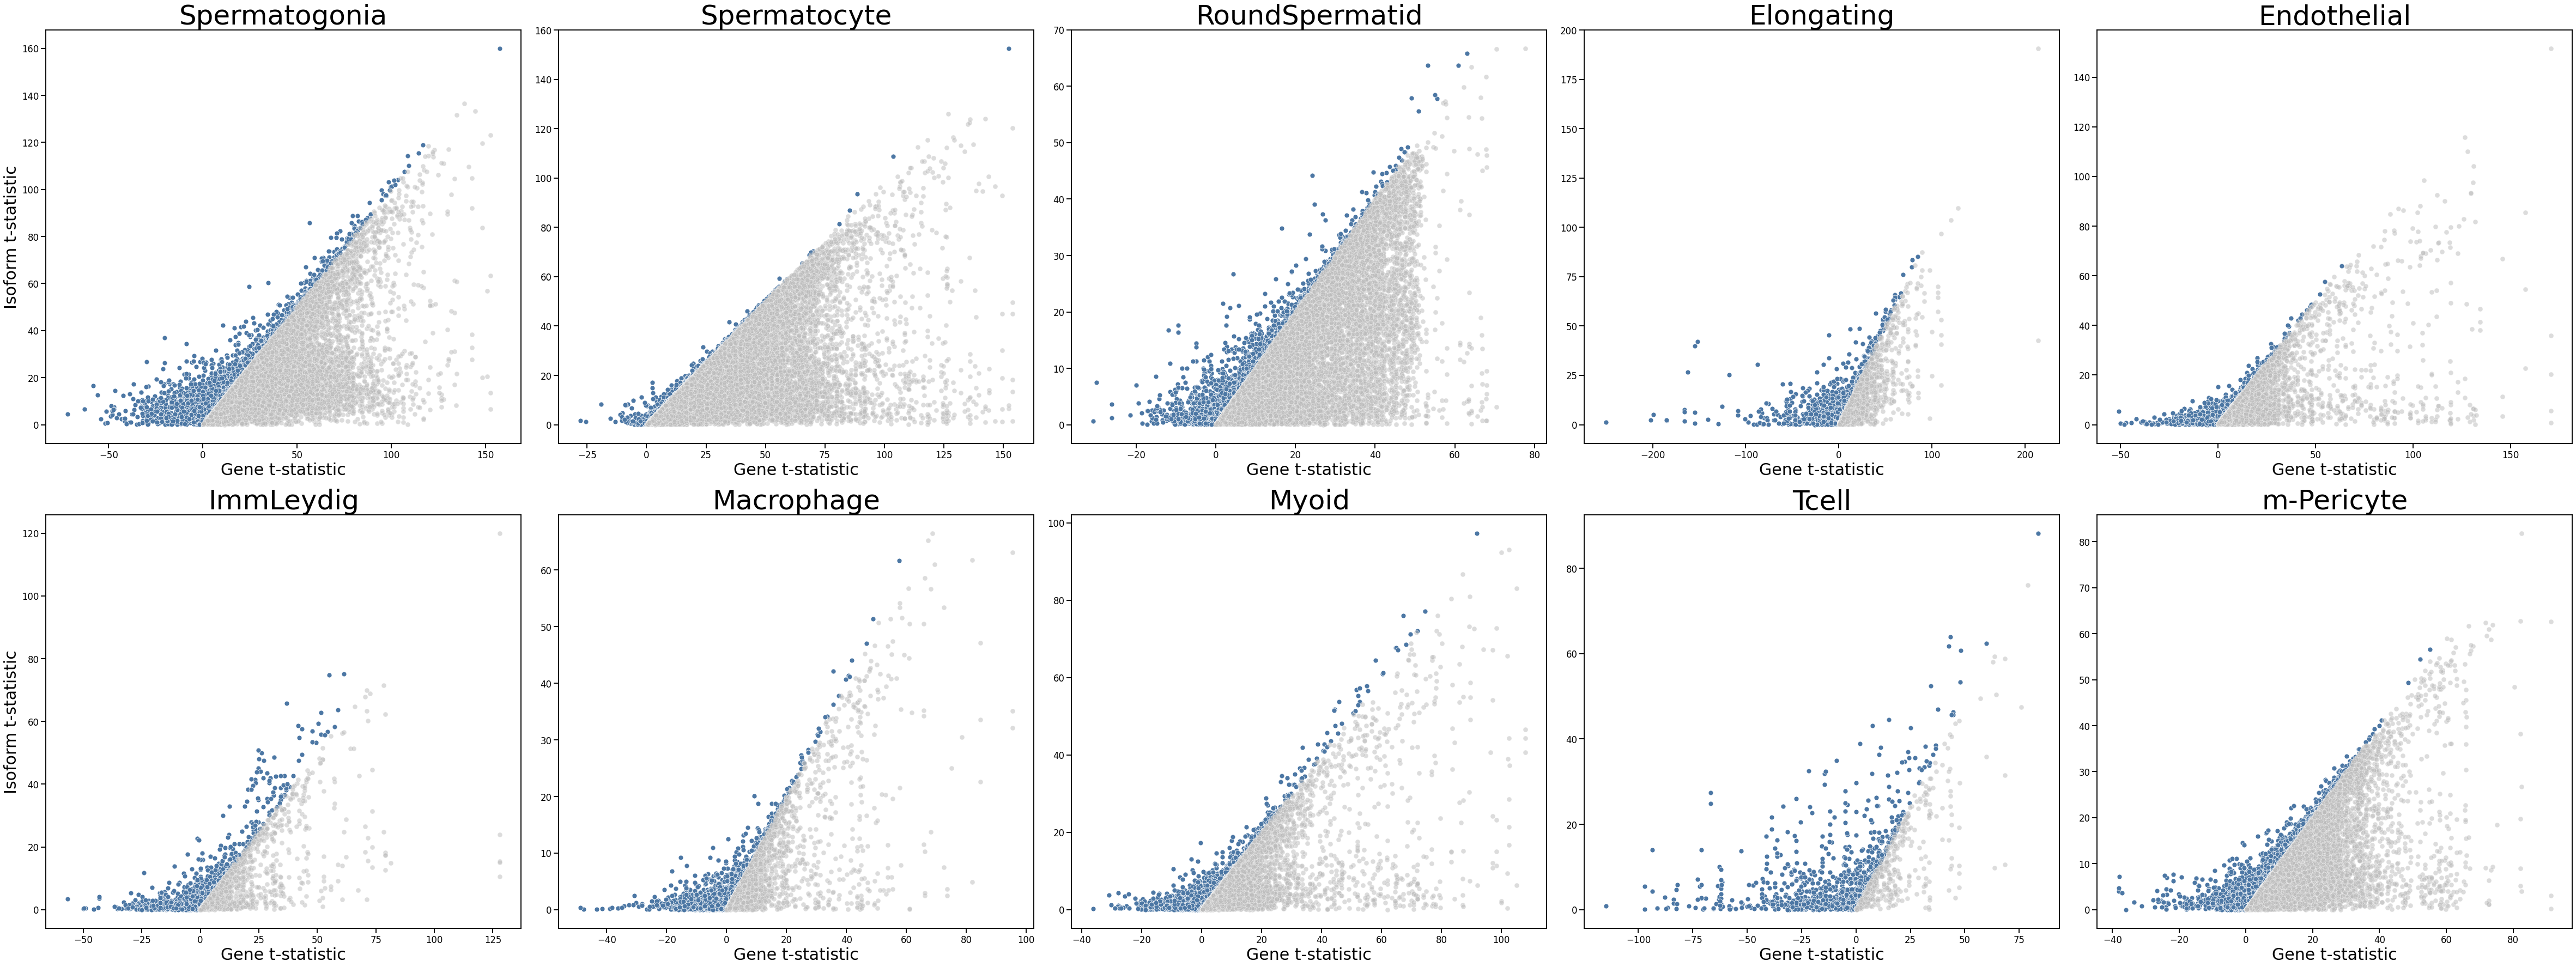

In [13]:
# sns.set_context('poster')
fig, ax = plt.subplots(2, 5, figsize = (66, 25))
i = 0
for celltype, axis in zip(celltypes, ax.flatten()):
    df = isoforms_genes_results_tiso[celltype]
    
    mask = df['t-statistic_gene'] < df['t-statistic_isoform']

    sns.scatterplot(data = df[mask], x = 't-statistic_gene', y = 't-statistic_isoform', alpha = 1 , ax = axis, color = "#4C77A4")
    sns.scatterplot(data = df[~mask], x = 't-statistic_gene', y = 't-statistic_isoform', alpha = 0.5 , ax = axis, color = '#BBBBBB')
    
    
        
#     if len(df[df.transcript_id == 'ENST00000551241.5']) > 0:
#         print(celltype)
#         sns.scatterplot(data = df[df.transcript_id == 'ENST00000551241.5'], x = 't-statistic_gene', y = 't-statistic_isoform', 
#                         alpha = 1 , ax = axis, color = "orange", s = 1000)


    axis.set_title(celltype, fontsize = 50)
    #axis.set_xlim(0,)
    #axis.set_ylim(0,)
    if i%5 == 0:
        axis.set_ylabel('Isoform t-statistic', fontsize = 30)
        axis.set_xlabel('Gene t-statistic', fontsize = 30)
    else:
        axis.set_ylabel('')
        axis.set_xlabel('Gene t-statistic', fontsize = 30)
    i+=1
    i+=1
fig.tight_layout()

!mkdir -p figures
plt.savefig('figures/fig_3b.png')

